# Demo Notebook: Facial Attribute Estimation

#### Eunyoung Hwang, December 2020


This demo notebook is created to introduce the idea of Facial Attribute Estimation, which the processing of facial attribute extraction and predicting the results of an image. Among various algorithms of facial attribute estimation, we mainly use FaceNet model to implement. The implemented model will detect age, gender, and some facial attributes of an image. The codes are mostly based on Human Attributes Detection with Facial Feature Extraction by Weblineindia. (https://github.com/weblineindia/AIML-Human-Attributes-Detection-with-Facial-Feature-Extraction)

## Configuration (Ulf)

In [7]:
# General configuration
import os

# data_directory: str
#     Path to a directory to store data.
data_directory = '.'

# webcam: int
#     An integer indicating the number of the webcam to be used. If there is just
#     one webcam, this will usually be 0.
webcam = 1

# install_missing_packages: bool
#     A flag indicating if missing packages should be automatically installed
install_missing_packages = True

# use_conda: bool
#     A flag indicating if conda should be used for software installation.
#     If False, pip will be used. The default is to use conda if jupyter
#     is run in a conda environment.
use_conda = 'CONDA_EXE' in os.environ

# gpu_available: bool
#     A flag indicating if a dedicated graphical processing unit (GPU), that is
#     CUDA enabled (NVIDIA) graphic card is available. If this is the case,
#     some software packages may use specialized code that can significantly
#     (by a factor of 10-20) increase performance.
gpu_available = True

## Preparations (Ulf)

In [8]:
import importlib

def check_package(package, pip_pkg: str = None, conda_pkg: str = None):
    """Check if a given package is installed. If missing install
    it (if global flag `install_missing_packages` is True) either with
    pip or with conda (depending on `use_conda`).
    """
    if importlib.util.find_spec(package) is not None:
        return  # ok, package is already installed

    if not install_missing_packages:
        raise RuntimeError(f"{package} is not installed!")

    if use_conda:
        import conda.cli
        conda.cli.main('conda', 'install',  '-y', conda_pkg or package)
    else:
        import subprocess
        import sys            
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pip_pkg or package])
        
        
# This is to exit cells without error tracebacks (cosmetic purpose)
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

## Requirements

To run all of this notebook, you need the following libraries to be installed:
* MatPlotLib (`matplotlib`): mainly for displaying images in the notebook
* OpenCv (`opencv=4.1.0`): for loading images and color space conversion
* Dlib (`dlib`): to detect faces and landmarks
* Skimage (`scikit-image`): for histogram equalization
* ImageIO (`imageio` and `imageio-ffmpeg`): for accessing the webcam
* Imutils (`imutils`): for using the face aligner by Adrian Rosebrock
* Mxnet(`mxnet_moon/`)

Running the following cell will create a file `fae_demo.yml` that can be used to setup a conda environment containing the required packages. 

In [290]:
%%writefile fae_demo.yml
name: fae_demo
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.8
  - jupyter
  - imageio
  - imageio-ffmpeg
  - matplotlib
  - opencv
  - mxnet
  - dlib
  - imutils

Overwriting fae_demo.yml


## Setting up the envrionment

Running the following cell will create a file `fae_demo.yml` that can be used to setup a conda environment containing the required packages. To do so, open a shell and type
```sh
conda env create -f fae_demo.yml
```
Remember that after running this command you have to activate the environment (Linux/MacOS: `conda activate fae_demo`, Windows: `activate fae_demo`) and then start jupyter in that environment.

In [185]:
import os
import cv2
import sys
import glob
import logging
import argparse
import dlib
import imageio
import imutils
import numpy as np
import mxnet as mx
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
from imutils.face_utils import shape_to_np
from imutils.face_utils import FACIAL_LANDMARKS_IDXS
#import model.emotion.detectemotion as ime
from mxnet_moon.lightened_moon import lightened_moon_feature

In [32]:
#Load path
faceProto = "opencv_face_detector.pbtxt"
faceModel = "opencv_face_detector_uint8.pb"
ageProto = "age_deploy.prototxt"
ageModel = "age_net.caffemodel"
genderProto = "gender_deploy.prototxt"
genderModel = "gender_net.caffemodel"



In [33]:
#Load face detection model
faceNet=cv2.dnn.readNet(faceModel,faceProto)
#Load age detection model
ageNet=cv2.dnn.readNet(ageModel,ageProto)
#Load gender detection model
genderNet=cv2.dnn.readNet(genderModel,genderProto)


In [280]:
#Detects face and extracts the coordinates
def getFaceBox(net, image, conf_threshold=0.7):
    image=image.copy()
    imageHeight=image.shape[0]
    imageWidth=image.shape[1]
    blob=cv2.dnn.blobFromImage(image, 1.0, (300, 300), [104, 117, 123], True, False)
    net.setInput(blob)
    detections=net.forward()
    faceBoxes=[]
    for i in range(detections.shape[2]):
        confidence=detections[0,0,i,2]
        if confidence>conf_threshold:
            x1=int(detections[0,0,i,3]*imageWidth)
            y1=int(detections[0,0,i,4]*imageHeight)
            x2=int(detections[0,0,i,5]*imageWidth)
            y2=int(detections[0,0,i,6]*imageHeight)
            faceBoxes.append([x1,y1,x2,y2])
            cv2.rectangle(image, (x1,y1), (x2,y2), (0,255,0), int(round(imageHeight/150)), 8)
    return image, faceBoxes

In [281]:
""" Detects age and gender """
def genderAge(image,faceBox):

    MODEL_MEAN_VALUES=(78.4263377603, 87.7689143744, 114.895847746)
    ageList=['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
    genderList=['Male','Female']
    
    padding=20
    face=image[max(0,faceBox[1]-padding):
        min(faceBox[3]+padding,image.shape[0]-1),max(0,faceBox[0]-padding)
        :min(faceBox[2]+padding, image.shape[1]-1)]
    blob=cv2.dnn.blobFromImage(face, 1.0, (227,227), MODEL_MEAN_VALUES, swapRB=False)

    # Predict the gender
    genderNet.setInput(blob)
    genderPreds=genderNet.forward()
    gender=genderList[genderPreds[0].argmax()]
    # Predict the age
    ageNet.setInput(blob)
    agePreds=ageNet.forward()
    age=ageList[agePreds[0].argmax()]
    # Return
    return gender,age


In [282]:
# Detect the facial attributes using mxnet
def main():
   # aligned_img = find_and_align_faces(image, BGR_INPUT=True)
   # aligned_img = np.asarray(alinged_img) #convert list into numpy
    resultImg, faceBoxes = getFaceBox(faceNet, image)
    if not faceBoxes:
        print("No face detected")
        
    for faceBox in faceBoxes:  
        # gender, age
        plt.imshow(bgr_to_rgb(image))
        plt.axis('off')
        plt.show()
        gender, age = genderAge(image, faceBox)
        print('gender', gender)
        print('age', age)
        

        # face attribute
        left = faceBox[0]
        width = faceBox[2] - faceBox[0]
        top = faceBox[1]
        height =  faceBox[3] - faceBox[1]
        right = faceBox[2]
        bottom = faceBox[3]
        gray = bgr_to_gray(image)
        pad = [0.25, 0.25, 0.25, 0.25] #if args.pad is None else args.pad
        left = int(max(0, left - width*float(pad[0])))
        top = int(max(0, top - height*float(pad[1])))
        right = int(min(gray.shape[1], right + width*float(pad[2])))
        bottom = int(min(gray.shape[0], bottom + height*float(pad[3])))
        gray = gray[left:right, top:bottom]
        
        # resizing image and increasing the image size
        gray = cv2.resize(gray, (args.size, args.size))/255.0
        img = np.expand_dims(np.expand_dims(gray, axis=0), axis=0)
        
        
        # get image parameter from mxnet
        mxnet: prediction or classification
        arg_params['data'] = mx.nd.array(img, devs)
        exector = symbol.bind(devs, arg_params ,args_grad=None, grad_req="null", aux_states=aux_params)
        exector.forward(is_train=False)
        exector.outputs[0].wait_to_read()
        output = exector.outputs[0].asnumpy()
        
        # 40 facial attributes
        text = ["5_o_Clock_Shadow","Arched_Eyebrows","Attractive","Bags_Under_Eyes","Bald", "Bangs","Big_Lips","Big_Nose",
            "Black_Hair","Blond_Hair","Blurry","Brown_Hair","Bushy_Eyebrows","Chubby","Double_Chin","Eyeglasses","Goatee",
            "Gray_Hair", "Heavy_Makeup","High_Cheekbones","Male","Mouth_Slightly_Open","Mustache","Narrow_Eyes","No_Beard",
            "Oval_Face","Pale_Skin","Pointy_Nose","Receding_Hairline","Rosy_Cheeks","Sideburns","Smiling","Straight_Hair",
            "Wavy_Hair","Wearing_Earrings","Wearing_Hat","Wearing_Lipstick","Wearing_Necklace","Wearing_Necktie","Young"]

        #Predict the results
        pred = np.ones(40)
        # create a list based on the attributes generated.
        print('attribute')
        attrDict = {}
        detectedAttributeList = []
        for i in range(40):
            attr = text[i].rjust(20)
            if output[0][i] < 0:
                attrDict[attr] = 'No'
            else:
                attrDict[attr] = 'Yes'
                detectedAttributeList.append(text[i])        
        for attribute in detectedAttributeList:
            print(attribute)                  
 

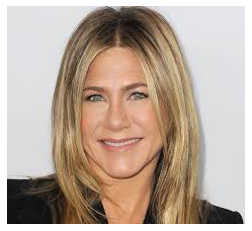

gender Female
age (25-32)
attribute
Attractive
Blond_Hair
Heavy_Makeup
High_Cheekbones
Mouth_Slightly_Open
No_Beard
Oval_Face
Pointy_Nose
Smiling
Straight_Hair
Wearing_Lipstick
Young


In [283]:
image = cv2.imread("images/image1.jpg")
main()

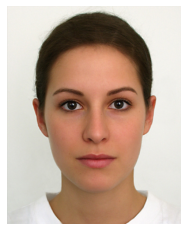

gender Male
age (25-32)
attribute
Arched_Eyebrows
Attractive
Big_Lips
Black_Hair
Bushy_Eyebrows
Heavy_Makeup
High_Cheekbones
Mouth_Slightly_Open
No_Beard
Oval_Face
Pointy_Nose
Smiling
Straight_Hair
Wearing_Lipstick
Young


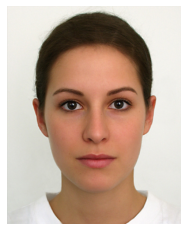

gender Male
age (25-32)
attribute
Arched_Eyebrows
Attractive
Big_Lips
Black_Hair
Bushy_Eyebrows
Heavy_Makeup
No_Beard
Pointy_Nose
Straight_Hair
Wearing_Lipstick
Young


In [284]:
image = cv2.imread("images/image2.jpg")
main()

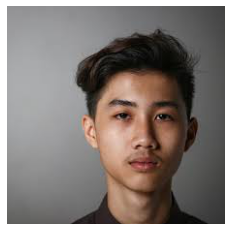

gender Male
age (15-20)
attribute
5_o_Clock_Shadow
Attractive
Black_Hair
Bushy_Eyebrows
Male
No_Beard
Pointy_Nose
Straight_Hair
Young


In [286]:
image = cv2.imread("images/image4.jpeg")
main()

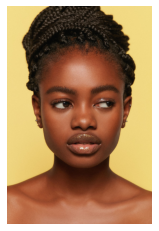

gender Male
age (25-32)
attribute
Bags_Under_Eyes
Big_Lips
Big_Nose
Black_Hair
Bushy_Eyebrows
High_Cheekbones
Male
Mouth_Slightly_Open
No_Beard
Smiling
Wavy_Hair
Young


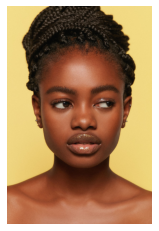

gender Female
age (8-12)
attribute
Attractive
Bangs
Black_Hair
Male
No_Beard
Straight_Hair
Young


In [287]:
image = cv2.imread("images/image6.jpg")
main()

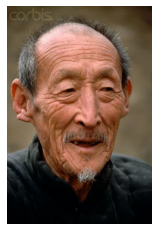

gender Male
age (38-43)
attribute
Bags_Under_Eyes
Big_Nose
Chubby
Double_Chin
Goatee
Gray_Hair
High_Cheekbones
Male
Mouth_Slightly_Open
Sideburns
Smiling


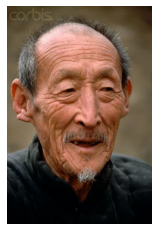

gender Male
age (25-32)
attribute
Bags_Under_Eyes
Big_Nose
Eyeglasses
Gray_Hair
Male
Mouth_Slightly_Open
Narrow_Eyes
No_Beard


In [288]:
image = cv2.imread("images/image8.jpg")
main()